# Artificial Neural Networks and Deep Learning

---

## Homework 2: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 2` in your Google Drive.
2. Upload the `mars_for_students.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 2 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.csv` file to Kaggle.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/MyDrive/Polimi/ANNDL/challenge2

Mounted at /gdrive
/gdrive/MyDrive/Polimi/ANNDL/challenge2


## ⚙️ Import Libraries

In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

from datetime import datetime
import pandas as pd
from collections import Counter
from scipy.ndimage import label

import cv2

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [3]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

# Separiamo il train set in training e validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42  # 20% per il validation set
)

# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
###
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)

print(f"Training X shape: {X_train.shape}")
print(f"Validation X shape: {X_val.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2004, 64, 128, 1)
Validation X shape: (501, 64, 128, 1)
Training y shape: (2004, 64, 128)
Test X shape: (10022, 64, 128, 1)


In [4]:
category_map = {
  0: 0, #Background
  1: 1, #Soil
  2: 2, #Bedrock
  3: 3, #Sand
  4: 4, #Big Rock
}

In [5]:
def visualize_image_label_pairs(X, y, num_images, class_names, reverse=0):
    """
    Visualize pairs of original images and their corresponding label overlays,
    and add a color legend for the labels.

    Args:
        X: Array of images (shape: [num_samples, height, width, channels]).
        y: Array of labels (shape: [num_samples, height, width]).
        num_images: Number of image-label pairs to visualize.
        class_names: List of class names (optional). If provided, a legend will be added.
    """

    if reverse == 1:
        X = X[::-1]
        y = y[::-1]

    # Set up the grid layout: 2 columns, num_images rows
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

    # Define a custom colormap for the legend
    if class_names is not None:
        cmap = mcolors.ListedColormap(plt.cm.jet(np.linspace(0, 1, len(class_names))))
        norm = mcolors.BoundaryNorm(np.arange(len(class_names)+1), len(class_names))
    else:
        cmap = 'jet'
        norm = None

    for i in range(num_images):
        # Extract the image and its corresponding label
        image = X[i]
        label = y[i]

        # Show the original image in the first column
        ax = axes[i, 0] if num_images > 1 else axes[0]
        ax.imshow(image.squeeze(), cmap='gray')  # Use squeeze for grayscale images
        ax.axis('off')
        ax.set_title(f"Image {i+1}")

        # Show the image with the label overlay in the second column
        ax = axes[i, 1] if num_images > 1 else axes[1]
        ax.imshow(image.squeeze(), cmap='gray')  # Background: original image
        ax.imshow(label, alpha=0.5, cmap=cmap, norm=norm)  # Label overlay
        ax.axis('off')
        ax.set_title(f"Label Overlay {i+1}")

    # Add the legend if class names are provided
    if class_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(class_names))]
        plt.legend(handles, class_names, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

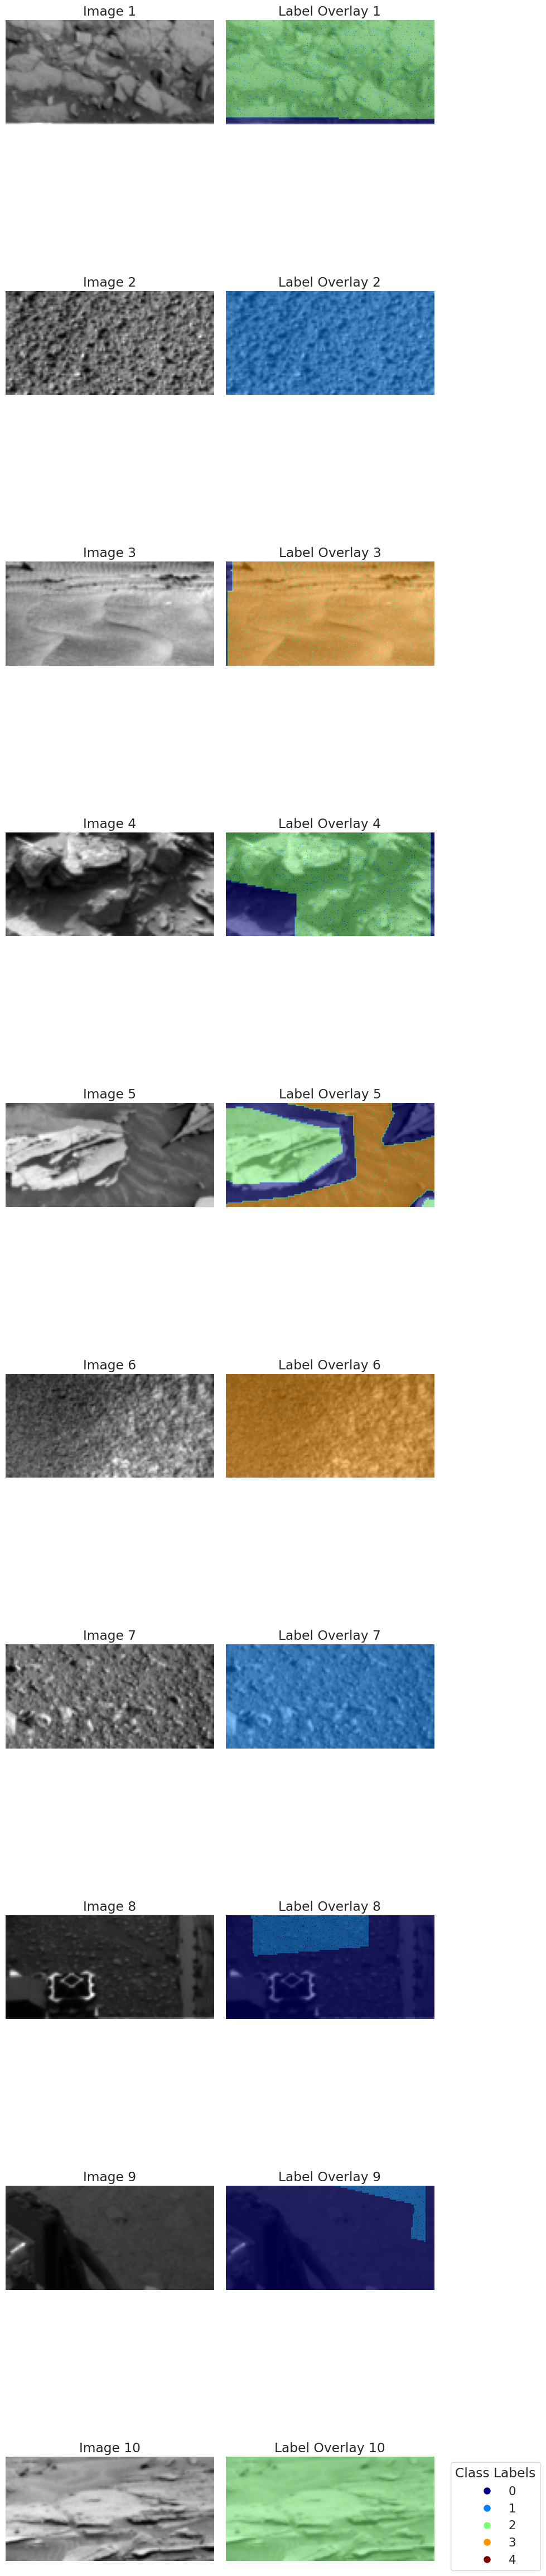

In [6]:
visualize_image_label_pairs(X_train, y_train, num_images=10, class_names=category_map, reverse=1)

##Apply augmentation

In [7]:
def rotate_image_and_label(image, label, angle):
    """
    Rotate an image and its corresponding label by a given angle.

    Parameters:
    - image: The image to rotate (H, W, C).
    - label: The label (segmentation mask) to rotate (H, W).
    - angle: The angle (in degrees) by which to rotate.

    Returns:
    - rotated_image: Rotated image.
    - rotated_label: Rotated label.
    """
    # Get image dimensions
    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    # Rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate image
    rotated_image = cv2.warpAffine(
        image,
        rotation_matrix,
        (w, h),
        flags=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_REFLECT_101
    )

    # Rotate label (nearest neighbor to preserve integer values)
    rotated_label = cv2.warpAffine(
        label,
        rotation_matrix,
        (w, h),
        flags=cv2.INTER_NEAREST,
        borderMode=cv2.BORDER_REFLECT_101
    )

    return rotated_image, rotated_label

def augment_data(X, y, num_augmentations=1):
    """
    Perform data augmentation on the dataset (rotation, flipping).

    Parameters:
    - X: array of images (num_samples, height, width, channels).
    - y: array of labels (segmentation masks) (num_samples, height, width).
    - num_augmentations: Number of augmentations to generate for each image.

    Returns:
    - augmented_X: Augmented images.
    - augmented_y: Corresponding labels.
    """
    augmented_X, augmented_y = [], []

    for i in range(len(X)):
        image = X[i]
        label = y[i]

        for _ in range(num_augmentations):
            # Random rotation
            angle = np.random.uniform(-45, 45)  # Random angle between -45 and 45 degrees
            rotated_image, rotated_label = rotate_image_and_label(image[..., 0], label, angle)

            # Restore the channel dimension for rotated image
            rotated_image = rotated_image[..., np.newaxis]

            # Optionally apply flips
            if np.random.rand() > 0.5:
                rotated_image = np.fliplr(rotated_image)
                rotated_label = np.fliplr(rotated_label)

            if np.random.rand() > 0.5:
                rotated_image = np.flipud(rotated_image)
                rotated_label = np.flipud(rotated_label)

            augmented_X.append(rotated_image)
            augmented_y.append(rotated_label)

    return np.array(augmented_X), np.array(augmented_y)

In [8]:
X_aug, y_aug = augment_data(X_train, y_train, num_augmentations=2)

# Concatenate original data with augmented data
X_train_augmented = np.concatenate((X_train, X_aug), axis=0)
y_train_augmented = np.concatenate((y_train, y_aug), axis=0)

# Print dataset shapes
print(f"Original training set size: {X_train.shape}")
print(f"Augmented training set size: {X_train_augmented.shape}")
print(f"Original labels size: {y_train.shape}")
print(f"Augmented labels size: {y_train_augmented.shape}")

X_train = X_train_augmented
y_train = y_train_augmented

Original training set size: (2004, 64, 128, 1)
Augmented training set size: (6012, 64, 128, 1)
Original labels size: (2004, 64, 128)
Augmented labels size: (6012, 64, 128)


Visualizing examples from the training set:


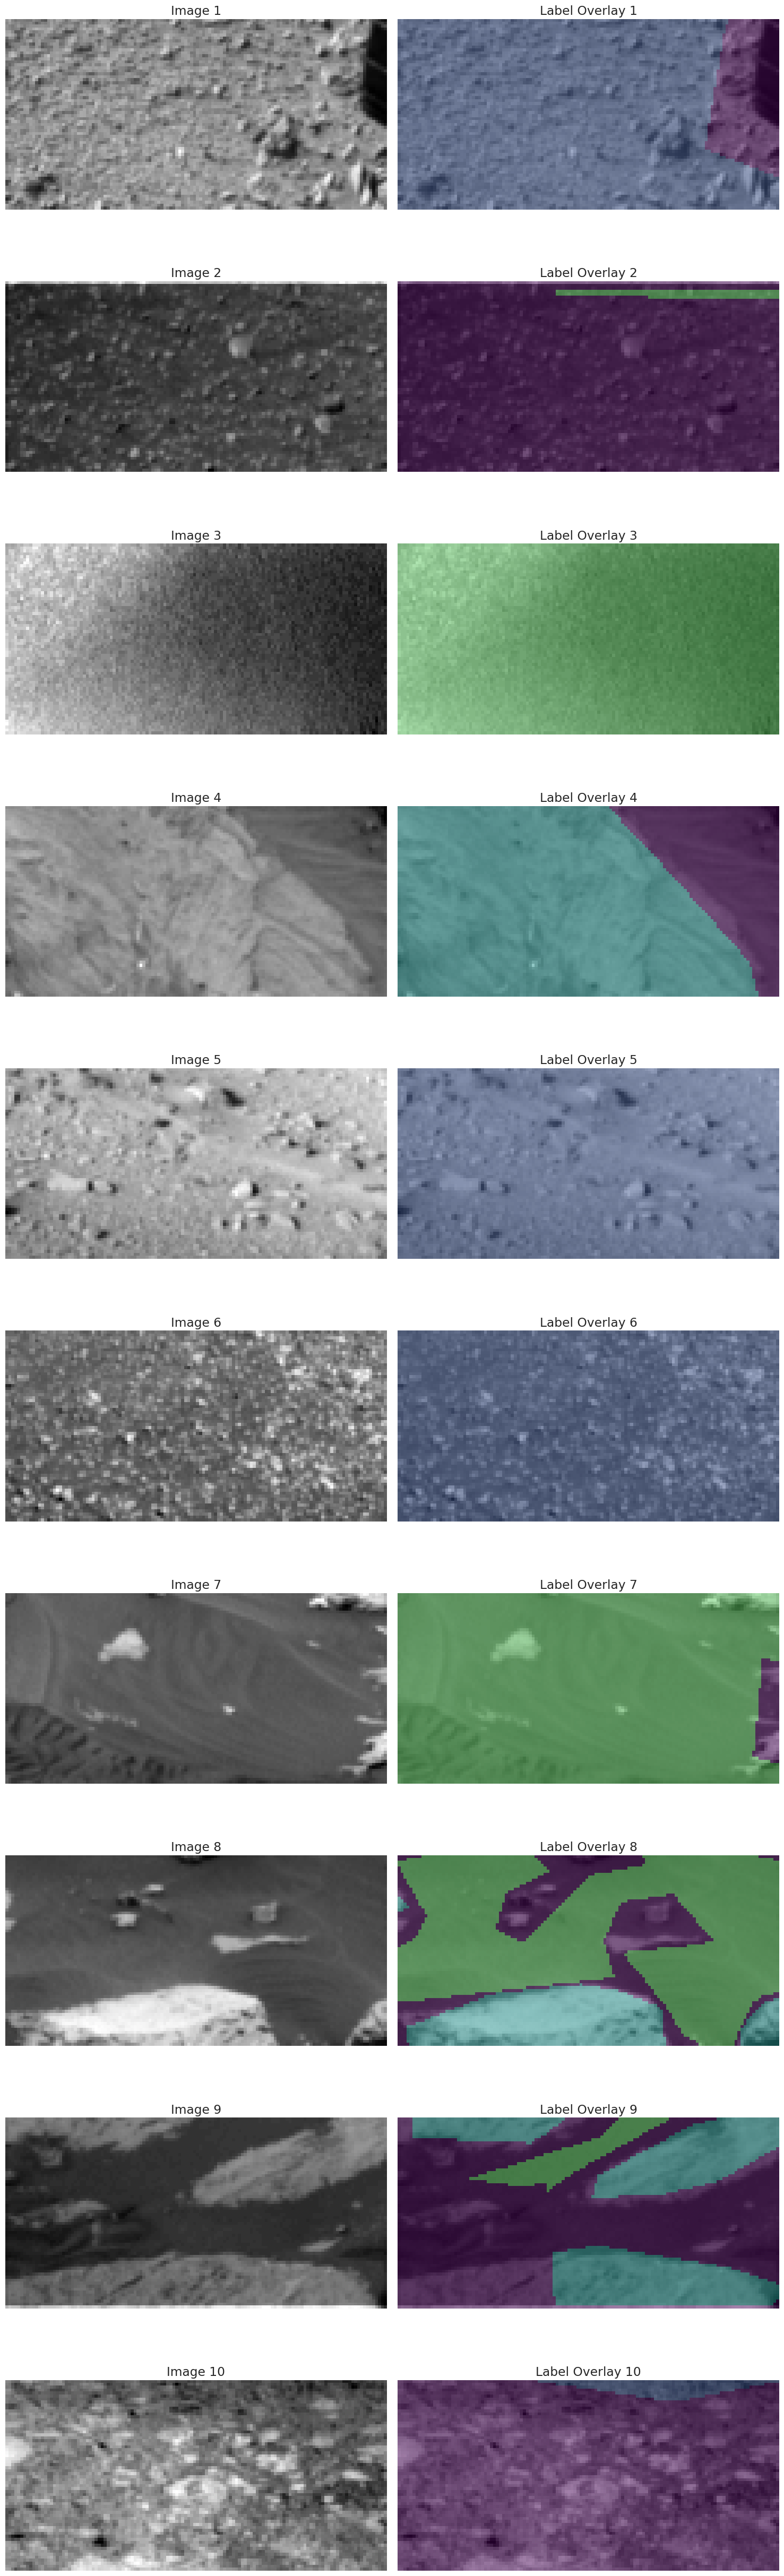

In [9]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(x, y, num_samples=3, class_names=None):
    """
    Display some image and label pairs with label overlays.
    Parameters:
    - x: Array of images.
    - y: Array of labels.
    - num_samples: Number of samples to display.
    - class_names: List of class names for the legend.
    """
    plt.figure(figsize=(15, 5 * num_samples))

    num_classes = len(np.unique(y))
    colormap = create_segmentation_colormap(num_classes)

    for j in range(min(num_samples, len(x))):
        # Plot original image
        plt.subplot(num_samples, 2, j * 2 + 1)
        plt.imshow(x[j].squeeze(), cmap='gray')  # Display grayscale image
        plt.title(f'Image {j+1}')
        plt.axis('off')

        # Plot image with label overlay
        plt.subplot(num_samples, 2, j * 2 + 2)
        plt.imshow(x[j].squeeze(), cmap='gray')  # Display grayscale image as background
        colored_label = apply_colormap(y[j], colormap)
        plt.imshow(colored_label, alpha=0.5)  # Overlay label with transparency
        plt.title(f'Label Overlay {j+1}')
        plt.axis('off')

    # Add legend if class names are provided
    if class_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colormap[i], markersize=10)
                   for i in range(len(class_names))]
        plt.legend(handles, class_names, title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    plt.close()

# Example usage
print("Visualizing examples from the training set:")
plot_sample_batch(X_train, y_train, num_samples=10)

##Build model

In [10]:
num_classes = len(np.unique(y_train))
input_shape = (64, 128, 1)

In [11]:
def residual_bottleneck(x, filters):
    shortcut = tfkl.Conv2D(filters, (1, 1), padding="same")(x)
    shortcut = tfkl.BatchNormalization()(shortcut)

    x = tfkl.Conv2D(filters, (3, 3), padding="same")(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Conv2D(filters, (3, 3), padding="same")(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Add()([x, shortcut])
    x = tfkl.ReLU()(x)
    return x

def unet(input_shape, num_classes):

    def conv_block(x, filters):
        x = tfkl.Conv2D(filters, (3, 3), padding="same")(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)
        x = tfkl.Conv2D(filters, (3, 3), padding="same")(x)
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)
        return x

    def encoder_block(x, filters):
        conv = conv_block(x, filters)
        pool = tfkl.MaxPooling2D((2, 2))(conv)
        return conv, pool

    def decoder_block(x, skip, filters):
        x = tfkl.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(x)
        x = tfkl.Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    inputs = tfkl.Input(input_shape)

    enc1, pool1 = encoder_block(inputs, 32)
    enc2, pool2 = encoder_block(pool1, 64)
    enc3, pool3 = encoder_block(pool2, 128)
    enc4, pool4 = encoder_block(pool3, 256)

    bottleneck = residual_bottleneck(pool4, 512)

    dec4 = decoder_block(bottleneck, enc4, 256)
    dec3 = decoder_block(dec4, enc3, 128)
    dec2 = decoder_block(dec3, enc2, 64)
    dec1 = decoder_block(dec2, enc1, 32)

    outputs = tfkl.Conv2D(num_classes, (1, 1), activation="softmax")(dec1)

    return Model(inputs, outputs)

model = unet(input_shape=(64, 128, 1), num_classes=5)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 128, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 128, 32)    │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 128, 32)    │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 64, 128, 32)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 128, 32)    │          9,248 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 128, 32)    │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 64, 128, 32)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, 64, 32)     │              0 │ re_lu_1[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 64, 64)     │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 64, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 32, 64, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 64, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 32, 64, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 32, 64, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, 32, 64)     │              0 │ re_lu_3[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 32, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 7,905,061 (30.16 MB)

 Trainable params: 7,898,149 (30.13 MB)

 Non-trainable params: 6,912 (27.00 KB)

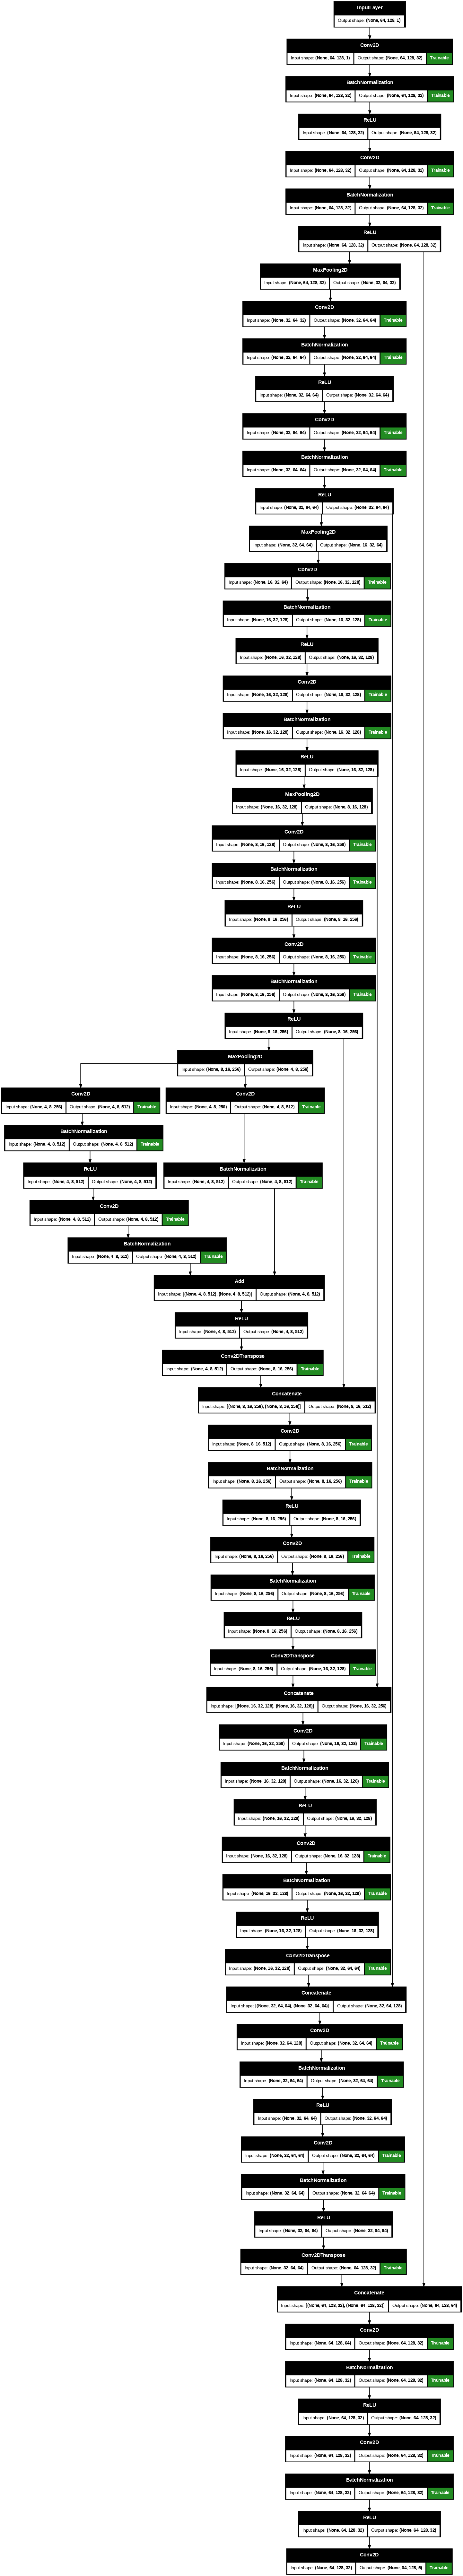

In [12]:
model.summary()
# Visualize the model and save the image
tfk.utils.plot_model(model, show_trainable=True, show_shapes=True, dpi=70)

## 🛠️ Train and Save the Model

[0.0, 0.1864610037297438, 0.22562799305491923, 0.2511484714339748, 0.3367625317813621]


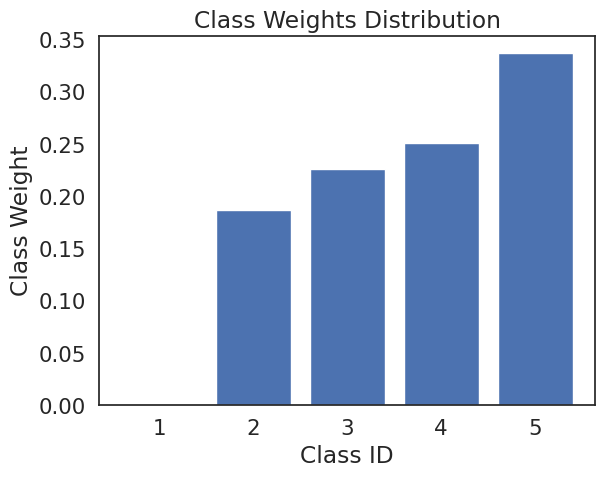

In [13]:
# Funzione per calcolare i pesi delle classi come percentuali
def calculate_class_weights(X_train, y_train, exponent=2):
    class_counts = Counter()  # Contatore per il numero di occorrenze per ciascuna classe
    total_pixels = 0  # Numero totale di pixel in tutto il dataset

    # Itera su ogni immagine nel dataset
    for i in range(X_train.shape[0]):
        mask = y_train[i]  # Ottieni la maschera di classe per l'immagine
        unique_classes = np.unique(mask)  # Trova tutte le classi uniche (eccetto la classe di background, 0)

        # Per ogni classe presente nell'immagine
        for class_id in unique_classes:
            if class_id == 0:  # Ignora la classe di background (0)
                continue
            # Conta il numero di pixel per classe
            class_counts[class_id] += np.sum(mask == class_id)
            total_pixels += mask.size  # Aggiungi il numero di pixel di questa immagine

    # Creare un dizionario dei pesi per ciascuna classe
    class_weights = []

    # Calcolare il peso delle classi come inversamente proporzionale al numero di occorrenze
    for class_id in range(1, max(class_counts.keys()) + 1):  # Itera su tutte le classi (ignorando lo sfondo)
        class_pixel_count = class_counts.get(class_id, 1)  # Default a 1 se la classe non è presente
        # Calcolare il peso come inversamente proporzionale alla frequenza della classe
        class_weight = (1 - (class_pixel_count / total_pixels)) ** exponent
        class_weights.append(class_weight)

    # Normalizzare i pesi in modo che sommino a 1
    weight_sum = sum(class_weights)
    class_weights = [weight / weight_sum for weight in class_weights]
    class_weights.insert(0, 0.0)

    return class_weights

# Esempio di utilizzo:
# X_train = np.array([...])  # Immagini in bianco e nero (N, H, W)
# y_train = np.array([...])  # Etichette dei pixel (N, H, W)
class_weights = calculate_class_weights(X_train, y_train, exponent=2)

# Stampa i pesi delle classi in formato array (0: peso, 1: peso, ...)
print(class_weights)

# Grafico per visualizzare la distribuzione dei pesi
plt.bar(range(1, len(class_weights) + 1), class_weights)
plt.xlabel('Class ID')
plt.ylabel('Class Weight')
plt.title('Class Weights Distribution')
plt.show()

In [14]:
# Funzione di loss pesata
def weighted_loss(class_weights):
    def loss(y_true, y_pred):
        # Converti class_weights in un tensore
        weights = tf.constant(class_weights, dtype=tf.float32)

        # Assicurati che y_true sia un intero
        y_true = tf.cast(y_true, dtype=tf.int32)

        # Calcola la perdita base (senza pesi)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

        # Calcola i pesi per ogni classe (moltiplicando per il valore corrispondente)
        pixel_weights = tf.gather(weights, y_true)

        # Applica i pesi alla perdita
        weighted_loss = loss * pixel_weights

        # Restituisci la perdita media
        return tf.reduce_mean(weighted_loss)

    return loss

In [15]:
# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

loss_function = weighted_loss(class_weights)

model.compile(optimizer="adam", loss=loss_function, metrics=[mean_iou])

In [16]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop after 10 epochs without improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

# Learning rate scheduler (ReduceLR on Plateau)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',   # Monitor validation loss
    factor=0.5,           # Reduce learning rate by 50%
    patience=3,           # Wait for 3 epochs before reducing LR
    min_lr=1e-6           # Minimum learning rate
)

In [17]:
# Train the model with early stopping and learning rate scheduler
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 55s 141ms/step - loss: 0.1908 - mean_io_u: 0.2082 - val_loss: 0.6622 - val_mean_io_u: 0.0656 - learning_rate: 0.0010
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.1191 - mean_io_u: 0.4007 - val_loss: 0.5829 - val_mean_io_u: 0.0697 - learning_rate: 0.0010
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.1005 - mean_io_u: 0.4579 - val_loss: 0.3505 - val_mean_io_u: 0.2177 - learning_rate: 0.0010
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0864 - mean_io_u: 0.5024 - val_loss: 0.1532 - val_mean_io_u: 0.3782 - learning_rate: 0.0010
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0791 - mean_io_u: 0.5205 - val_loss: 0.1582 - val_mean_io_u: 0.3021 - learning_rate: 0.0010
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0747 - mean_io_u: 0.5317 - val_loss: 0.0974 - val_mean_io_u: 0.4957 - learning_rate: 0.0010
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 

In [18]:
# Save the trained model to a file with the accuracy included in the filename
model_filename = 'model14.keras'
model.save(model_filename)

##Results

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step


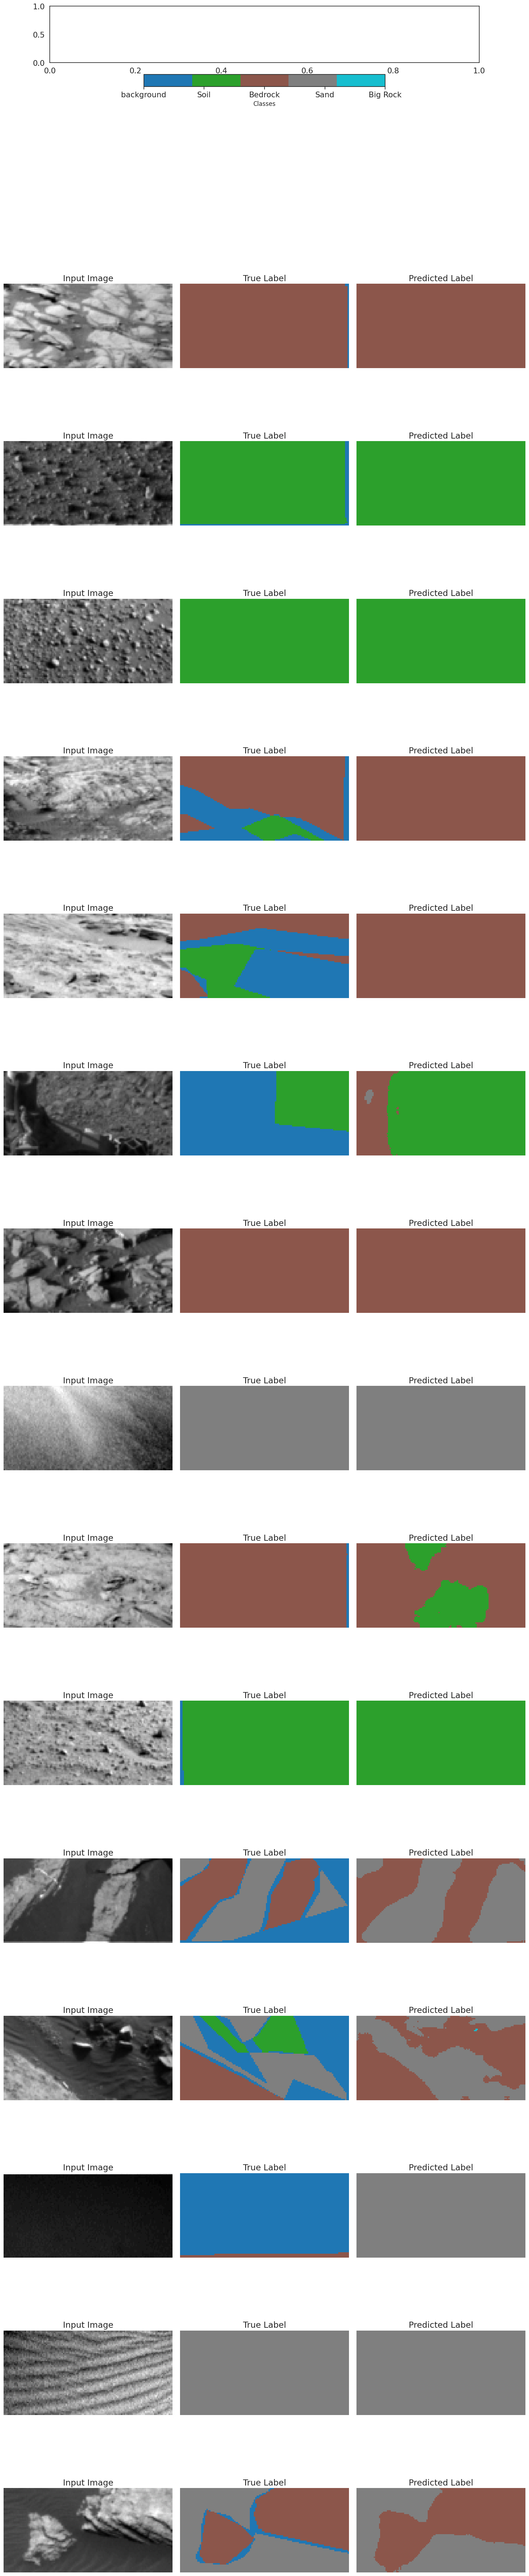

In [19]:
# Make predictions on the validation set
predictions = model.predict(X_val)
predicted_classes = np.argmax(predictions, axis=-1)

# Function to visualize predictions with class legend at the top
def visualize_predictions_with_legend(X, y_true, y_pred, class_names, num_examples=5):
    """
    Visualize predictions vs true labels for the validation set with a legend at the top.
    Args:
        X: Input images (validation set).
        y_true: True labels.
        y_pred: Predicted labels.
        class_names: List of class names corresponding to the labels.
        num_examples: Number of examples to visualize.
    """
    # Define the colormap
    num_classes = len(class_names)
    cmap = plt.cm.get_cmap('tab10', num_classes)

    # Create the figure
    plt.figure(figsize=(15, num_examples * 5))

    # Add the legend as a standalone colorbar at the top
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=num_classes - 1)),
        ax=plt.gcf().add_axes([0.1, 0.95, 0.8, 0.03]),  # Position of the colorbar (top of the figure)
        orientation='horizontal'
    )
    cbar.set_ticks(range(num_classes))
    cbar.set_ticklabels(class_names)
    cbar.set_label("Classes", fontsize=12)

    # Visualize each example
    for i in range(num_examples):
        # Input image
        plt.subplot(num_examples, 3, i * 3 + 1)
        plt.imshow(X[i, :, :, 0], cmap='gray')  # Show the grayscale input
        plt.title("Input Image")
        plt.axis('off')

        # True label
        plt.subplot(num_examples, 3, i * 3 + 2)
        plt.imshow(y_true[i], cmap=cmap, vmin=0, vmax=num_classes - 1)  # Show true labels
        plt.title("True Label")
        plt.axis('off')

        # Predicted label
        plt.subplot(num_examples, 3, i * 3 + 3)
        plt.imshow(y_pred[i], cmap=cmap, vmin=0, vmax=num_classes - 1)  # Show predicted labels
        plt.title("Predicted Label")
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Leave space at the top for the colorbar
    plt.show()

# Define the class names
class_names = ["background","Soil","Bedrock","Sand", "Big Rock"]

# Visualize predictions on the first few examples
visualize_predictions_with_legend(X_val, y_val, predicted_classes, class_names, num_examples=15)

## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [20]:
model = tfk.models.load_model('model14.keras', compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model14.keras


In [21]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
Predictions shape: (10022, 64, 128)


In [22]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [23]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>